In [3]:

import pandas as pd
import os
import shapely.geometry as sg
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point, MultiPoint
from shapely.ops import unary_union
data_directory = os.path.join('..', 'data', 'ptv', '20240224')



ROUTE_TYPES = {
    0 : 'Tram',
    1 : 'Metro',
    2 : 'Rail',
    3 : 'Bus',
    4 : 'Ferry',
    5 : 'Cable tram',
    6 : 'Gondola',
    7 : 'Funicular',
    11 : 'Trolleybus',
    12 : 'Monorail',
}
ROUTE_TYPES_LONG = {
    0 : 'Tram, Streetcar, Light rail. Any light rail or street level system within a metropolitan area.',
    1 : 'Subway, Metro. Any underground rail system within a metropolitan area.',
    2 : 'Rail. Used for intercity or long-distance travel.',
    3 : 'Bus. Used for short- and long-distance bus routes.',
    4 : 'Ferry. Used for short- and long-distance boat service.',
    5 : 'Cable tram. Used for street-level rail cars where the cable runs beneath the vehicle, e.g., cable car in San Francisco.',
    6 : 'Aerial lift, suspended cable car (e.g., gondola lift, aerial tramway). Cable transport where cabins, cars, gondolas or open chairs are suspended by means of one or more cables.',
    7 : 'Funicular. Any rail system designed for steep inclines.',
    11 : 'Trolleybus. Electric buses that draw power from overhead wires using poles.',
    12 : 'Monorail. Railway in which the track consists of a single rail or a beam.',
}

BRANCH_IDS_ALL = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11']
BRANCH_IDS = ['1', '2', '3', '4', '5', '6', '10', '11']
TABLE_NAMES = ['stop_times', 'stops', 'trips', 'routes', 'calendar', 'calendar_dates', 'agency', 'shapes']
# GTFS File Fields
# agency.txt 
# agency_id, agency_name, agency_url, agency_timezone, agency_lang
# calendar.txt 
# service_id, monday, tuesday, wednesday, thursday, friday, saturday, sunday, start_date, end_date
# calendar_dates.txt 
# service_id ,date, exception_type
# routes.txt 
# route_id, agency_id, route_short_name, route_long_name,
# route_type, route_color,route_text_color
# trips.txt 
# route_id, service_id, trip_id, shape_id, trip_headsign, direction_id
# stops.txt 
# stop_id, stop_name, stop_lat, stop_lon
# stop_times.txt 
# trip_id, arrival_time, departure_time, stop_id, stop_sequence, stop_headsign, pickup_type, drop_off_type, shape_dist_traveled
# shapes.txt 
# shape_id, shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled 
def get_df(branch_id, table_name):
    files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.split('-')[1] == str(branch_id) and f.split('-')[2] == table_name]
    if len(files) == 0:
        return None
    return pd.concat([pd.read_csv(f, keep_default_na=False, na_values=['']) for f in files])

DF = {branch_id: {table_name: get_df(branch_id, table_name) for table_name in TABLE_NAMES} for branch_id in BRANCH_IDS_ALL}
# 15s - 30s



In [213]:

for bid in BRANCH_IDS:
    DF[bid]['shapes'].sort_values(by=['shape_id', 'shape_pt_sequence'], inplace=True)
    DF[bid]['shapes']['points'] = list(zip(DF[bid]['shapes']['shape_pt_lon'], DF[bid]['shapes']['shape_pt_lat']))
    DF[bid]['lines'] = DF[bid]['shapes'].groupby('shape_id')['points'].apply(np.array).rename('line').reset_index()
    DF[bid]['lines']['direction'] = DF[bid]['lines']['shape_id'].transform(lambda x: x.split('.')[-1])
    DF[bid]['lines']['route_id'] = DF[bid]['lines']['shape_id'].transform(lambda x: x.split('.')[0])
    DF[bid]['lines']['route_name'] = DF[bid]['lines']['route_id'].transform(lambda x: ''.join(x.split('-')[1:-2]))
    DF[bid]['lines']['branch'] = DF[bid]['lines']['route_id'].transform(lambda x: x.split('-')[0])
    DF[bid]['lines']['opbranch'] = bid

# Total 2m    
    
DFLINES : pd.DataFrame = pd.concat([DF[bid]['lines'] for bid in BRANCH_IDS])

DFLINES['points_count'] = DFLINES['line'].apply(len)

DFLINES = DFLINES[['route_name', 'direction', 'branch', 'opbranch', 'route_id', 'shape_id', 'line', 'points_count']]

DFLINES.sort_values(
    by=['opbranch', 'route_name', 'branch', 'direction', 'points_count'], 
    ascending=[True, True, True, True, False],
    inplace=True, 
)

DFLINES.reset_index(drop=True, inplace=True)

# Total: 1m 30s - 2m

def find_smallest_number_of_lists(lists):
    # Create a set to store all unique elements from all lists
    all_elements = set()
    for lst in lists:
        all_elements.update(lst)

    # Initialize an empty list to store the selected lists
    selected_lists = []

    # Iterate until all elements are covered
    while all_elements:
        # Find the list that covers the maximum number of uncovered elements
        max_covered = set()
        max_list = None
        for lst in lists:
            covered = set(lst).intersection(all_elements)
            if len(covered) > len(max_covered):
                max_covered = covered
                max_list = lst

        # Remove covered elements from the set of all elements
        all_elements.difference_update(max_covered)

        # Add the selected list to the result
        selected_lists.append(max_list)

    return selected_lists
# 30s - 1m


In [6]:
DFLINES['segments'] = DFLINES['line'].apply(lambda x: [(x[i], x[i+1]) for i in range(len(x)-1)])
# 10s - 20s

In [12]:
DF_SEGMENTS = DFLINES.explode('segments').reset_index(drop=True)
# 10s - 20s

In [14]:
DF_SEGMENTS = DF_SEGMENTS[['route_name', 'direction', 'branch', 'opbranch', 'route_id', 'shape_id', 'segments']]

In [59]:
DF_SEGMENTS_MIN = DF_SEGMENTS.drop_duplicates(subset=['route_name', 'direction', 'opbranch', 'segments'], keep='first')[['route_name', 'direction', 'opbranch', 'segments']]
# 12s - 20s
DF_SEGMENTS_MIN = DF_SEGMENTS_MIN.groupby(['route_name', 'direction', 'opbranch'])['segments'].apply(np.array).reset_index()
DF_SEGMENTS_MIN['segments'] = DF_SEGMENTS_MIN['segments'].transform(lambda segments: np.array([np.array([np.array(p) for p in segment]) for segment in segments]))

In [136]:
def merge_directed_paths(input_paths : np.ndarray[np.ndarray[np.ndarray]]) -> np.ndarray[np.ndarray[np.ndarray]]:
    # Make sure input_paths is a numpy array of numpy arrays of numpy arrays
    input_paths = np.array([np.array([np.array(p) for p in path]) for path in input_paths])
    merged_paths = []
    for path in input_paths:
        merged = False
        for i, existing_path in enumerate(merged_paths):
            if all(path[0] == existing_path[-1]):
                merged_paths[i] = np.concatenate([existing_path, path[1:]], axis=0)
                merged = True
                break
            elif all(path[-1] == existing_path[0]):
                merged_paths[i] = np.concatenate([path[:-1], existing_path], axis=0)
                merged = True
                break
        if not merged:
            merged_paths.append(path)

    # Remove consecutive duplicates
    for i, path in enumerate(merged_paths):
        merged_paths[i] = path[np.concatenate([[True], np.any(path[1:] != path[:-1], axis=1)])]

    # Remove paths that are < 2 points
    merged_paths = [path for path in merged_paths if len(path) > 1]
    return merged_paths


In [137]:
DF_SEGMENTS_MIN['paths'] = DF_SEGMENTS_MIN['segments'].apply(lambda x: merge_directed_paths(x))
# 7s - 15s

In [144]:
DF_SEGMENTS_MIN['segments_count'] = DF_SEGMENTS_MIN['segments'].apply(len)
DF_SEGMENTS_MIN['paths_count'] = DF_SEGMENTS_MIN['paths'].apply(len)

In [146]:
DF_SEGMENTS_MIN['geometry'] = DF_SEGMENTS_MIN['paths'].apply(lambda x: MultiLineString(x) if len(x) > 1 else LineString(x[0]))

In [148]:
GDF = gpd.GeoDataFrame(DF_SEGMENTS_MIN[['route_name', 'direction', 'opbranch', 'geometry']], geometry='geometry')

In [150]:
GDF.to_file('../data/ptv/ptv-lines.geojson', driver='GeoJSON')
# 5s - 10s

In [151]:
GDF.groupby('opbranch').apply(lambda x: x.to_file(f'../data/ptv/ptv-lines-{x.name}.geojson', driver='GeoJSON'))

""


In [216]:
df4_lines = DFLINES[DFLINES['opbranch'] == '4'].groupby(['route_name', 'direction', 'opbranch'])['line'].apply(np.array).rename('lines').reset_index()

In [221]:
df4_lines['geometry'] = df4_lines['lines'].apply(lambda x: MultiLineString([LineString(l) for l in x]) if len(x) > 1 else LineString(x[0]))

In [223]:
gdf4 = gpd.GeoDataFrame(df4_lines[['route_name', 'direction', 'geometry']], geometry='geometry')

In [224]:
gdf4.to_file('../data/ptv/ptv-lines-4-x.geojson', driver='GeoJSON')

In [214]:
len(DFLINES[DFLINES['opbranch'] == '4'])

2114

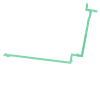

In [228]:
DF_SEGMENTS_MIN[DF_SEGMENTS_MIN['route_name'] == '703']['geometry'].iloc[0]


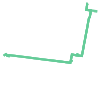

In [229]:
df4_lines[df4_lines['route_name'] == '703']['geometry'].iloc[0]